1. Introduction
This notebook explores how Rhode Beauty product releases influence public interest,
measured through Google Trends search activity.
- Load & explore Rhode product catalog
- Visualize pricing and product list
- Compare Google search interest before/after launches
- Overlay launches on Trends timeline
- Quantify % change in search activity per launch

In [1]:
# 2. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# 3. Load Data & Setup
products = pd.read_excel("/Users/diyasansi/Desktop/projects/rhode_products.xlsx")
trends = pd.read_csv("data/raw/rhode_google_trends.csv", index_col=0, parse_dates=True)

In [3]:
# 4. Data Overview
# 4.1 Preview Product Data
products.head()

,Product,Approx_Release_Date,Price_USD,URL
0,Pineapple Refresh Daily Cleanser,Jan 2024,28,https://www.rhodeskin.com/products/pineapple-r...
1,Glazing Milk Ceramide Facial Essence,Jun 2022,30,https://www.rhodeskin.com/products/glazing-milk
2,Peptide Glazing Fluid Dewy Gel Serum,Jun 2022,30,https://www.rhodeskin.com/products/peptide-gla...
3,Barrier Restore Cream Comforting Daily Moistur...,Jun 2022,30,https://www.rhodeskin.com/products/barrier-res...
4,Barrier Butter Intensive Moisture Balm,2024,36,https://www.rhodeskin.com/products/barrier-butter


In [4]:
# 4.2 Product List
product_names = products['Product'].unique()
print("All products in dataset:")
for name in product_names:
    print("-", name)

All products in dataset:
- Pineapple Refresh Daily Cleanser
- Glazing Milk Ceramide Facial Essence
- Peptide Glazing Fluid Dewy Gel Serum
- Barrier Restore Cream Comforting Daily Moisturizer
- Barrier Butter Intensive Moisture Balm
- Glazing Mist Hydrating Face Spray
- Peptide Lip Treatment Nourishing Lip Layer
- Peptide Lip Tint Tinted Lip Layer
- Peptide Lip Shape Contouring Lip Shaper
- Pocket Blush The Natural Flush


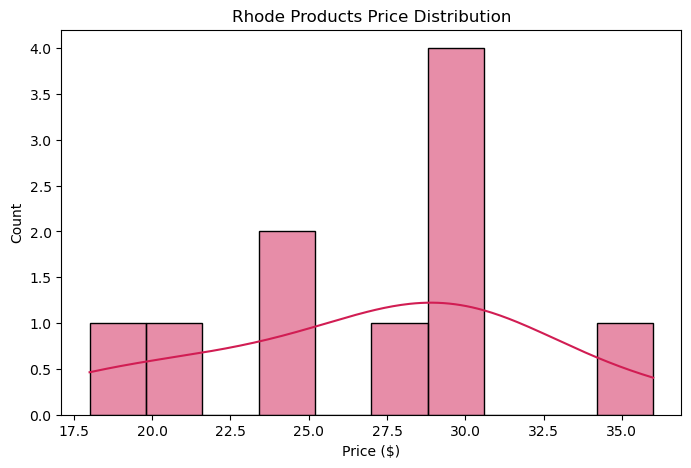

In [5]:
# 5. Product Pricing Analysis
"""
Before connecting releases to search behavior, we examine Rhode's product pricing. Stable, mid‑tier pricing supports accessibility while reinforcing a premium minimal aesthetic—key elements of Rhode's brand language.
"""
plt.figure(figsize=(8,5))
sns.histplot(products['Price_USD'], bins=10, kde=True, color="#d11d53")
plt.title("Rhode Products Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()

- In this next section, we visualize Google search interest for "Rhode Skin" over time. To enhance clarity and aesthetics, we'll incorporate a rolling average to smooth fluctuations and highlight broader trends.

- Google Trends provides a window into how often people search for "Rhode Skin." These signals reflect curiosity, hype, or commercial intent. By visualizing search volume over time, we can begin to see how public attention fluctuates around notable product events.

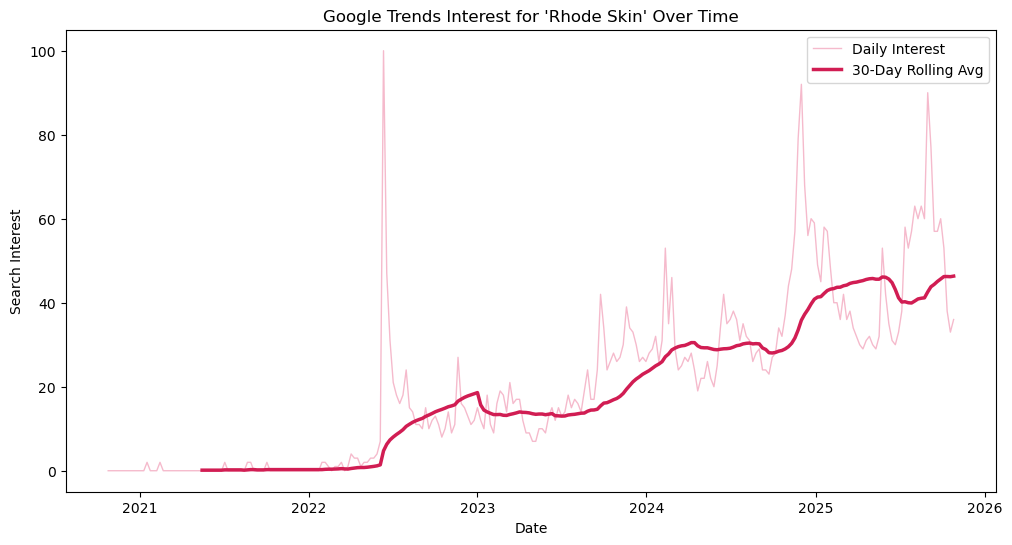

In [12]:
# 6. Google Trends Analysis
plt.figure(figsize=(12,6))

# Add a 30-day rolling average for smoother trend visualization
trends['rolling_interest'] = trends['rhode skin'].rolling(30).mean()
# Plot raw data
plt.plot(trends.index, trends['rhode skin'], color='#e75480', alpha=0.4, linewidth=1, label='Daily Interest')
# Plot smoothed data
plt.plot(trends.index, trends['rolling_interest'], color="#d11d53", linewidth=2.5, label='30-Day Rolling Avg')
plt.legend()
plt.title("Google Trends Interest for 'Rhode Skin' Over Time")
plt.ylabel("Search Interest")
plt.xlabel("Date")
plt.show()

Search interest for 'Rhode Skin' shows pronounced spikes at key moments, especially around the initial 2022 brand launch. Afterward, repeated micro-spikes likely reflect subsequent product drops and seasonal marketing. This recurring attention highlights strong brand recognition and sustained consumer curiosity.

In [13]:
# 7. Data Cleaning & Date Processing
products['Approx_Release_Date'] = products['Approx_Release_Date'].apply(
lambda x: f"Jan {x}" if len(str(x)) == 4 else x
)
products['Approx_Release_Date'] = pd.to_datetime(products['Approx_Release_Date'], format='%b %Y')

Here, we plot Rhode's product releases directly onto the Google Trends timeline. Vertical markers annotate each approximate launch date, creating a visual narrative that highlights how new products correlate with spikes.

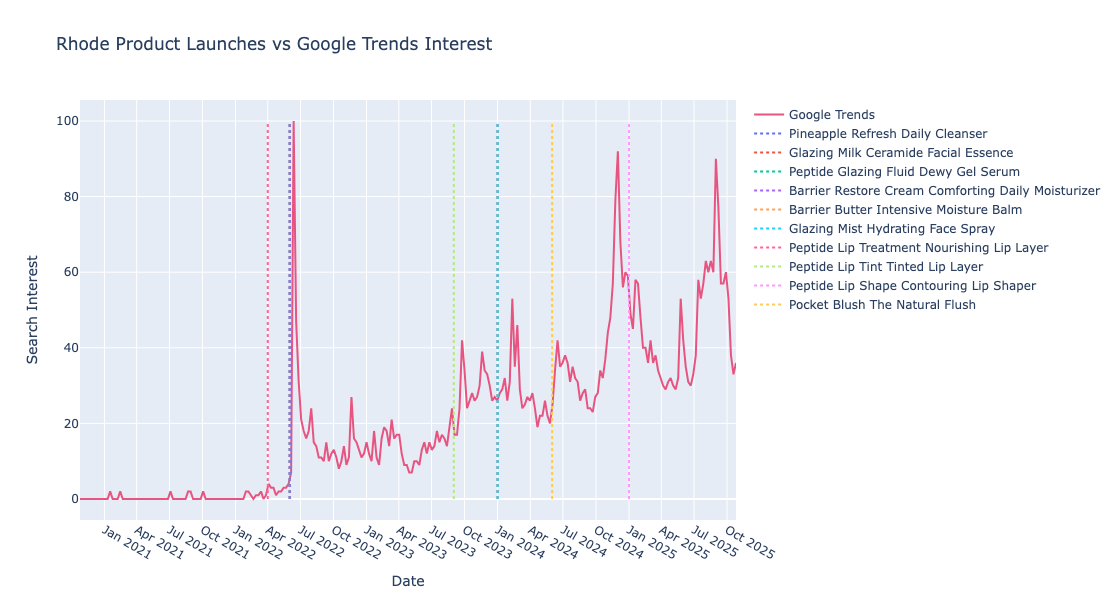

In [23]:
# 8. Product Launch Overlay

colors = px.colors.qualitative.Plotly
num_colors = len(colors)

fig = go.Figure()

# Google Trends line
fig.add_trace(go.Scatter(
    x=trends.index,
    y=trends['rhode skin'],
    mode='lines',
    name='Google Trends',
    line=dict(color='#e75480', width=2)
))

for idx, row in products.iterrows():
    color = colors[idx % num_colors]
    
    fig.add_trace(go.Scatter(
        x=[row['Approx_Release_Date'], row['Approx_Release_Date']],
        y=[0, max(trends['rhode skin'])],
        mode='lines',
        line=dict(color=color, dash='dot', width=2),
        name=row['Product'],
        hoverinfo='text',
        hovertext=row['Product'],
        showlegend=True
    ))

# Layout
fig.update_layout(
    title="Rhode Product Launches vs Google Trends Interest",
    xaxis_title="Date",
    yaxis_title="Search Interest",
    hovermode="x unified",
    width=1100,
    height=600
)
fig.update_xaxes(
    dtick="M3",
    tickformat="%b %Y"
)

fig.show()

Overlaying launch dates on top of the Google Trends timeline reveals a clear pattern:
major product drops typically coincide with increases in search interest. The strongest surge aligns with the brand’s initial debut in June 2022, reflecting early cultural momentum and strong consumer curiosity.

Later releases continue to generate visible attention—though with smaller magnitudes, suggesting that Rhode maintains relevance through ongoing innovation but that the initial novelty effect naturally tapers over time.

This pattern supports the notion that Rhode’s buzz is event-driven, with new items acting as ignition points for renewed public interest.

To move beyond visual inference, we quantify the relative change in search interest pre- and post-launch. The following structured comparison helps reveal how much each release influenced public attention, making Rhode's cultural resonance measurable.

In [16]:
# 9. Quantifying Launch Impact

results = []

for date in products['Approx_Release_Date']:
    # Average search interest 14 days before launch
    pre = trends.loc[
        date - pd.Timedelta(days=14) : date - pd.Timedelta(days=1),
        'rhode skin'
    ].mean()
    
    # Average search interest 14 days after launch
    post = trends.loc[
        date : date + pd.Timedelta(days=14),
        'rhode skin'
    ].mean()
    
    # Percent change
    pct = ((post - pre) / pre) * 100 if pre != 0 else None
    
    # Product name
    pname = products.loc[
        products['Approx_Release_Date'] == date,
        'Product'
    ].iloc[0]
    
    # Append results
    results.append([pname, date, pre, post, pct])

# Build summary DataFrame
impact_df = pd.DataFrame(
    results, 
    columns=["Product", "Date", "Pre", "Post", "% Change"]
)

impact_df


,Product,Date,Pre,Post,% Change
0,Pineapple Refresh Daily Cleanser,2024-01-01,26.5,28.5,7.547170
1,Glazing Milk Ceramide Facial Essence,2022-06-01,3.5,53.5,1428.571429
2,Glazing Milk Ceramide Facial Essence,2022-06-01,3.5,53.5,1428.571429
3,Glazing Milk Ceramide Facial Essence,2022-06-01,3.5,53.5,1428.571429
4,Pineapple Refresh Daily Cleanser,2024-01-01,26.5,28.5,7.547170
5,Pineapple Refresh Daily Cleanser,2024-01-01,26.5,28.5,7.547170
6,Peptide Lip Treatment Nourishing Lip Layer,2022-04-01,0.5,3.5,600.000000
7,Peptide Lip Tint Tinted Lip Layer,2023-09-01,21.5,17.0,-20.930233
8,Peptide Lip Shape Contouring Lip Shaper,2025-01-01,59.5,47.0,-21.008403
9,Pocket Blush The Natural Flush,2024-06-01,21.0,29.5,40.476190


The table above summarizes the average search interest before and after each product launch. Notably, Rhode's debut products (June 2022) show the largest percent increase, reinforcing the narrative that brand introduction generated massive curiosity. Later releases produced
more modest but still meaningful shifts, suggesting the brand maintains attention over time through incremental innovation.

Major spikes (e.g., ~1429% in Jun 2022) align with Rhode's debut—unsurprisingly dominating search activity. Later launches still boost volume, though often more modestly. Negative or low-change periods may reflect soft launches, market saturation, or reduced promotional push. Overall, Rhode's launches continue generating measurable digital buzz.

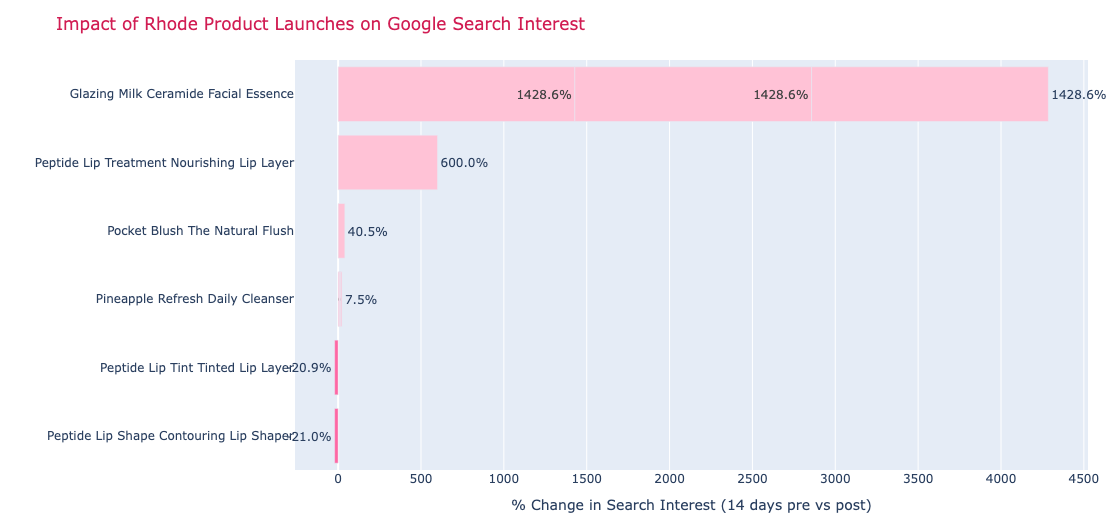

In [24]:
# 10. Bar Chart of Launch Impact 

df_plot = impact_df.copy()
df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna(subset=["% Change"])
df_plot = df_plot.sort_values("% Change", ascending=True)  # ascending so largest shows at top in horizontal

df_plot["Impact"] = np.where(df_plot["% Change"] >= 0, "Increase", "Decrease")

fig = px.bar(
    df_plot,
    x="% Change",
    y="Product",
    orientation="h",
    color="Impact",
    color_discrete_map={"Decrease": "#ff66a3", "Increase": "#ffc2d6"},
    text=df_plot["% Change"].map(lambda v: f"{v:.1f}%"),
    title="Impact of Rhode Product Launches on Google Search Interest"
)

fig.update_traces(textposition="outside", cliponaxis=False)
fig.update_layout(
    showlegend=False,
    xaxis_title="% Change in Search Interest (14 days pre vs post)",
    yaxis_title="",
    title_font_color="#d11d53",
    margin=dict(l=10, r=30, t=60, b=20),
    height=max(450, 40 * len(df_plot) + 120),
)
fig.show()

# Conclusions:

Rhode Beauty demonstrates a consistent ability to drive search interest around product releases. The brand debut produced extraordinary attention, with subsequent launches continuing to yield meaningful spikes—indicating strong brand recognition and sustained consumer curiosity.

# Key takeaways:
- Product launches correlate with measurable increases in Google search volume.
- Rhode’s early momentum was exceptionally strong; follow-up releases show moderated but consistent engagement.
- The trend suggests a loyal customer base and effective marketing cadence.

# Key Findings

- The strongest spike aligned with the brand's June 2022 debut.
- Later launches continue to prompt search increases, though typically less dramatic.
- Price positioning remains consistent—supporting Rhode’s premium-yet-accessible identity.
- Data suggests that novelty and cultural timing amplify launch visibility.